# 순환 신경망으로 IMDB 리뷰 분류하기, CPU

## IMDB 리뷰 데이터셋

In [1]:
import time

import numpy as np

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN    
from tensorflow.keras.layers import Embedding    
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import GRU    
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline  

from tensorflow.keras.datasets import imdb

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [2]:
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500) # 자주 등장하는 단어 500개만 사용

# 데이터 규모 확인, 25000은 list의 갯수
print(train_input.shape, test_input.shape) 
# 문장이 저장되어 있는데 1차원의 형태임.
print(type(train_input))

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


(25000,) (25000,)
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
# 단어는 너무 많아서 모두 표현 하기 어려움으로 500개로 지정됨.
# 500개의 단어에 등장하지 않는 단어는 2로 표현
# 첫번째 리뷰의 토큰 확인, 1: 문장 시작, 2: 어휘사전에 없는 데이터를 나타냄.
print(type(train_input[0]))# numpy는 <class 'list'>는 하나의 숫자처럼 인식됨.
print(train_input[0]) 

<class 'list'>
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [4]:
print(len(train_input[0])) # 첫번째 데이터 길이는 218개의 토큰으로 이루어짐.

218


In [5]:
print(len(train_input[1])) # 두번째 데이터 길이는 189개의 토큰으로 이루어짐.

189


In [6]:
print(train_target[:20]) # 20개의 타깃 확인, 0: 부정, 1: 긍정

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [7]:
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42) # 데이터 분할

In [8]:
# 리뷰의 길이 파악
lengths = np.array([len(x) for x in train_input]) 

In [9]:
print(lengths[0:10]) # 첫번째 리뷰는 259개의 단어로 구성됨.

[259 520 290 109 559  96 130 935 383 716]


In [10]:
# 리뷰의 규모를 파악하여 문장의 크기를 일정하게 만들고 타입스텝으로 사용
# 평균 239 단어, 중앙값은 178 단어
# 사람들은 평균 댓글 작성에 239 단어를 사용함
# 평균은 이상치의 영향을 받음으로 중앙값을 추가적으로 파악함.
# 전체 댓글 분포중에 중간에 위치한 단어의 수는 178단어로 평균보다 작음.
# 중앙값이 작음으로 댓글을 매우 길게 입력한 사용자 존재함.
print(np.mean(lengths), np.median(lengths))  

239.00925 178.0


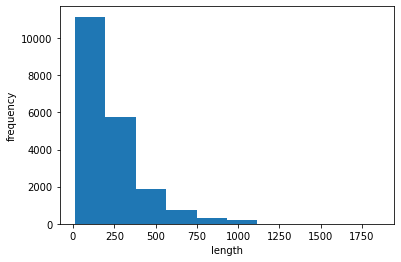

In [11]:
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()  # 이상치로인해 평균이 큰 값이 생성됨.

In [12]:
# 뒤쪽을 짜름, 하나의 문장은 100개의 단어로 구성됨.
train_seq = pad_sequences(train_input, maxlen=100, truncating='post')  

In [13]:
# 20000개의 문장이 있고 하나의 문장은 100 개의 단아로 구성됨.
print(train_seq.shape) 

(20000, 100)


In [14]:
# 100개의 토큰으로 줄어듬, 1개의 문장은 100개의 단어로 구성됨.
print(train_seq[0])  

[  1  73  89  81  25  60   2   6  20 141  17  14  31 127  12  60  28   2
   2  66  45   6  20  15 497   8  79  17 491   8 112   6   2  20  17   2
   2   4 436  20   9   2   6   2   7 493   2   6 185 250  24  55   2   5
  23 350   7  15  82  24  15   2  66  10  10  45   2  15   4  20   2   8
  30  17   2   5   2  17   2 190   4  20   9  43  32  99   2  18  15   8
 157  46  17   2   4   2   5   2   9  32]


In [15]:
print(train_input[0][0:10])  # 문장의 뒤쪽을 삭제 했는지 확인

[1, 73, 89, 81, 25, 60, 2, 6, 20, 141]


In [16]:
# 일반적으로 중요 문장은 뒤에 나온다고 가정하고 앞쪽을 짜름
train_seq = pad_sequences(train_input, maxlen=100) 

In [17]:
print(train_seq.shape)

(20000, 100)


In [18]:
print(train_seq[0])  # 100개의 토큰으로 줄어듬

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [19]:
# 첫번째의 마지막 10개의 토큰을 보니 앞부분이 짤림, 
print(train_input[0][-10:]) 

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [20]:
print(train_seq[5])  # 길이가 100개의 단어가 아니면 0으로 할당됨

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [21]:
val_seq = pad_sequences(val_input, maxlen=100)  # 검증 데이터의 크기 변경

### 자연어의 One-hot encoding

In [22]:
# one-hot encoding, 자연어 처리는 다중분류에 해당됨.
train_oh = to_categorical(train_seq) 

In [23]:
# 20000개의 문장, 100 타임 스텝(단어수), 500개의 단어
#       korea spring summer fall winter...500 단어
# korea   1     0      0     0     0
# spring  0     1      0     0     0
# summer  0     0      1     0     0.....포함된 단어의 표시
print(train_oh.shape)  

(20000, 100, 500)


In [24]:
# 첫번째 문장 첫번째 단어의 one-hot encoding 확인
print(train_oh[0][0][:500]) 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [25]:
print(np.sum(train_oh[0][0])) # one-hot encoding의 합은 1이되어야함

1.0


In [26]:
val_oh = to_categorical(val_seq)  # 검증 데이터 one-hot encoding

## 순환 신경망 훈련하기

In [27]:
model = Sequential()
# 100: 1개의 문장이 100개의 단어로 구성됨(timestep 수 100),
# 500: 원핫 인코딩된 값, 1개만 1이고 나머지는 0
# 활성화 함수는 기본 값인 tanh(하이퍼볼릭 탄젠트)를 사용
model.add(SimpleRNN(8, input_shape=(100, 500))) 
model.add(Dense(1, activation='sigmoid')) # 이항분류

# 단어수 500 * 뉴런수 8 = 4,000 개의 가중치
# 은닉 상태 8 * 뉴런수 8개 = 64개의 가중치
# 뉴런마다 1개의 절편: 8개
# 4,000 + 64 + 8 = 4072
# 출력: 뉴런수 8개 + 절편 1개
model.summary()

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('imdb_rnn.h5')
early_stopping = EarlyStopping(patience=1, restore_best_weights=True)

start = time.time()
hist = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint, early_stopping])

end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# cpu:  초, i5 8500:  초
# Colab cpu: 423 초, gpu: cpu보다 시간이 많이 소요됨

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 4072      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 25s 68ms/step - loss: 0.6977 - accuracy: 0.5068 - val_loss: 0.6965 - val_accuracy: 0.5060
Epoch 2/100
313/313 [==============================] - 21s 68ms/step - loss: 0.6936 - accuracy: 0.5168 - val_loss: 0.6933 - val_accuracy: 0.5174
Epoch 3/100
313/313 [==============================] - 21s 68ms/step - loss: 0.6898 - accuracy: 0.5330 - val_loss: 0.6897 - val_accuracy: 0.5338
Epoch 4/100
313/313 [==============================] - 21s 68ms/step - loss: 0.68

KeyboardInterrupt: ignored

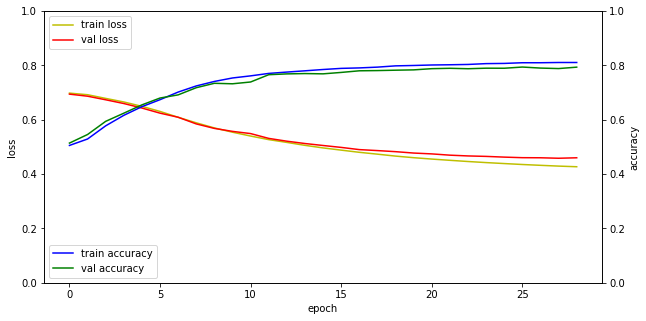

In [28]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [29]:
test_loss, test_acc = model.evaluate(val_oh, val_target, batch_size=64, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.45823758840560913 /정확도: 78.82000207901001 %


## 단어 임베딩을 사용하기
- One-Hot encoding은 유사도가 표현이 안되어 있음, 카운트 원리
- AI 학습에 의한 유사도(의미) 연산 지원
- RNN보다 빠른 연산 속도

In [28]:
model = Sequential()

# 500: 어휘 사전의 단어의 수
# 16: 임베딩 벡터의 크기, One-Hot encoding의 경우 하나의 문장을 500개의 데이터로 표현
#     단어 임베딩은 16개의 데이터로 표현 가능
# 100: 1개의 문장이 100개의 단어로 구성됨(timestep 수 100)
model.add(Embedding(500, 16, input_length=100))  
model.add(SimpleRNN(8))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint = ModelCheckpoint('imdb_rnn_embedding.h5')
early_stopping = EarlyStopping(patience=1, restore_best_weights=True)

start = time.time()
hist = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint, early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# Colab cpu: 77 s, cpu보다 시간이 많이 소요됨

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           8000      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 25s 76ms/step - loss: 0.6956 - accuracy: 0.5014 - val_loss: 0.6941 - val_accuracy: 0.5090
Epoch 2/100
313/313 [==============================] - 24s 76ms/step - loss: 0.6917 - accuracy: 0.5265 - val_loss: 0.6928 - val_accuracy: 0.5172
Epoch 3/100
154/313 [=============>................] - ETA: 11s - loss: 0.6896 - accuracy: 0

KeyboardInterrupt: ignored

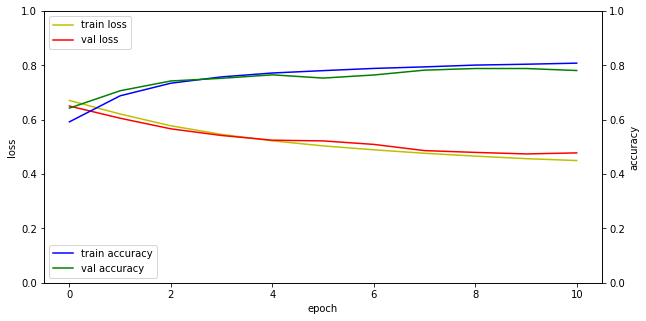

In [31]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [32]:
test_loss, test_acc = model.evaluate(val_seq, val_target, batch_size=64, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.47411710023880005 /정확도: 78.83999943733215 %
